In [296]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import freqz
%matplotlib inline

In [297]:
class FileUtilities(object):
	""" 
		Reads the CSI data 
	"""
	def __init__(self, path):
		super(FileUtilities, self).__init__()
		self.path = path
		self.data_matrices = []
		self.amplitude = []
		self.labels = []
		print("FileUtilities initialized")
		
	def read_csv(self,file):
		return pd.read_csv(file)

	def get_data_matrix(self,df):
		""" Returns the timestamps, amplitude and phase as a single matrix """
		return(df.as_matrix())

	def get_data_matrices(self):
		files = os.listdir(self.path)
		for file in files:
			df = self.read_csv(self.path+file)
			# label = str(str(file).split('-')[1])
			label = str(str(file).split('_')[3])
			self.labels.append(label)
			print("Reading " + str(file) + "...")
			data = self.get_data_matrix(df)
			self.data_matrices.append(data)
		print("FileUtilities::get_data_matrices read %d files" %(len(self.data_matrices)))
		return self.data_matrices

	def get_amplitude_matrices(self):
		if not self.data_matrices:
			self.get_data_matrices()
		for data_matrix in self.data_matrices:
			self.amplitude.append(np.array(data_matrix[:,1:]))		# for new data
			# self.amplitude.append(np.array(data_matrix[:,1:91]))
		return self.amplitude

In [298]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [299]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [321]:
# Filter requirements.
order = 5
fs = 80       # sample rate, Hz
cutoff = 10   # desired cutoff frequency of the filter, Hz

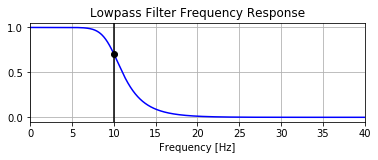

In [322]:
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)
# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

FileUtilities initialized


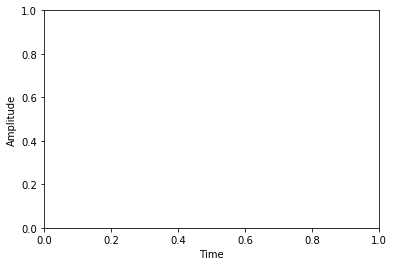

In [323]:
# plt.title('Cumulative Moving Variance over time')
plt.clf()
plt.xlabel('Time')
plt.ylabel('Amplitude')
path = '/Users/Apple/Documents/git-aryans/Wi-Chase/'
utl = FileUtilities(path)
input_file = '4-eating-parsed.csv'
df = utl.read_csv(path+input_file)
data = utl.get_data_matrix(df)
# plt.plot(range(1, CMV.shape[0]+1) , CMV)

In [324]:
input_file = '1-empty-parsed.csv'
df = utl.read_csv(path+input_file)
data1 = utl.get_data_matrix(df)
# plt.plot(range(1, CMV.shape[0]+1) , CMV)

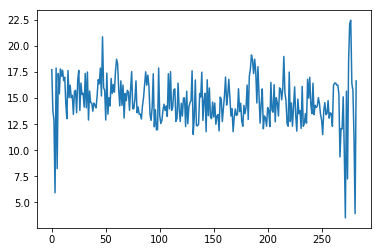

In [325]:
# s = data[:,1:31]
# s1 = np.sum(s,axis = 0)
s = data[:,1]
s1 = data1[:,1]
plt.plot(s)
# plt.plot(s1)

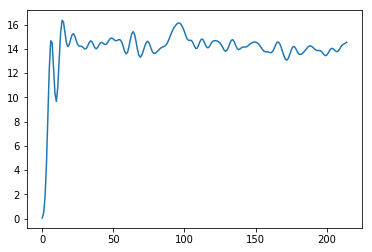

In [326]:
plt.clf()
y = butter_lowpass_filter(s1, cutoff, fs, order)
plt.plot(y)